In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
from os.path import join
import json
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm.auto import trange, tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
sys.path.append("/n/home12/binxuwang/Github/DiffusionLearningCurve")
sys.path.append("/Users/binxuwang/Github/DiffusionLearningCurve/")
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from core.toy_shape_dataset_lib import generate_random_star_shape_torch
from core.diffusion_basics_lib import *
from core.diffusion_edm_lib import *
from core.network_edm_lib import SongUNet, DhariwalUNet
from core.DiT_model_lib import *
from core.diffusion_nn_lib import UNetBlockStyleMLP_backbone
from circuit_toolkit.plot_utils import saveallforms, to_imgrid, show_imgrid
from pprint import pprint
from core.dataset_lib import load_dataset
from core.img_patch_stats_analysis_lib import compute_crossing_points, sweep_and_create_sample_store, process_img_mean_cov_statistics,\
     process_patch_mean_cov_statistics, plot_variance_trajectories, plot_mean_deviation_trajectories, \
     harmonic_mean, smooth_and_find_threshold_crossing
from core.trajectory_convergence_lib import smooth_and_find_threshold_crossing, compute_crossing_points, analyze_and_plot_variance
from core.img_patch_stats_analysis_lib import plot_variance_trajectories

saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"

In [3]:
def Gaussian_denoiser(Xt, Xmean, Xcov, sigma):
    """
    Gaussian denoiser
    """
    return Xt + sigma**2 * (Xmean.unsqueeze(0) - Xt) @ \
        (Xcov + sigma**2 * torch.eye(Xmean.shape[0])).inverse()
        
def Gaussian_denoiser_eigen(Xt, Xmean, Xcov_eigval, Xcov_eigvec, sigma):
    """
    Gaussian denoiser
    """
    residual = Xmean.unsqueeze(0) - Xt  # (B, D)
    residual_proj = (residual @ Xcov_eigvec) # (B, D)
    if isinstance(sigma, float):
        sigma = sigma * torch.ones(Xt.shape[0], 1, device=Xt.device)
    elif isinstance(sigma, torch.Tensor):
        if sigma.ndim == 1:
            sigma = sigma.unsqueeze(1)
        elif sigma.ndim == 2:
            pass
        elif sigma.ndim > 2:
            sigma = sigma.squeeze().unsqueeze(1)
        else:
            raise ValueError(f"sigma must be a float or a 1D or 2D tensor, but got {sigma.ndim}D tensor")
    scaling = sigma ** 2 / (sigma**2 + Xcov_eigval[None, :])
    rescaled_residual_proj = residual_proj * scaling # (B, D)
    return Xt + (rescaled_residual_proj @ Xcov_eigvec.T)#.view(Xt.shape)

In [4]:
from core.diffusion_esm_edm_lib import delta_GMM_denoiser
import pandas as pd
from tqdm import tqdm
@torch.no_grad()
def compute_model_mmse_comparison(models_dict, pnts, device, 
                                  num_reps: int | float = 20, num_noise_levels: int = 50, 
                                  batch_size: int | None = 1024,
                                  eigval: torch.Tensor | None = None,
                                  eigvec: torch.Tensor | None = None):
    """
    Compute MMSE comparison between different models and GMM denoiser across noise levels.
    
    Args:
        models_dict: Dictionary with model names as keys and model objects as values
        pnts: Training data points
        device: Device to run computation on
        
    Returns:
        DataFrame with MMSE statistics across noise levels
    """
    # pnts = pnts.to(device)
    trainX_mean = pnts.mean(0)
    if eigval is None or eigvec is None:
        eigval, eigvec = torch.linalg.eigh(torch.cov(pnts.T))
    # Create multiple noised versions for better evaluation
    if num_reps >= 1 and isinstance(num_reps, int):
        pnts_rep = pnts.repeat(num_reps, 1)
    elif num_reps < 1 and num_reps > 0 and isinstance(num_reps, float):
        # random select num_reps * pnts.shape[0] points
        # Randomly select a subset of points when num_reps is a fraction
        num_samples = int(num_reps * pnts.shape[0])
        random_indices = torch.randperm(pnts.shape[0])[:num_samples]
        pnts_rep = pnts[random_indices]
    else:
        raise ValueError(f"Invalid num_reps: {num_reps}")

    stats_col = []
    mmse_all_col = []
    for sigma in tqdm(np.logspace(np.log10(0.002), np.log10(100.0), num_noise_levels)):
        # Create all noised points and sigma vectors at once
        noised_pnts = pnts_rep + sigma * torch.randn(pnts_rep.shape[0], pnts.shape[1], device=pnts_rep.device)
        sigma_vec = torch.full((pnts_rep.shape[0],), sigma, )
        # Compute GMM denoiser reference
        # Batch evaluation for GMM denoiser
        if batch_size is not None:
            denoised_gmm = torch.zeros_like(noised_pnts)
            for i in range(0, noised_pnts.shape[0], batch_size):
                batch_noised = noised_pnts[i:i+batch_size]
                batch_sigma = sigma_vec[i:i+batch_size, None]
                denoised_batch = delta_GMM_denoiser(batch_noised.to(device), pnts.to(device), batch_sigma.to(device))
                denoised_gmm[i:i+batch_size] = denoised_batch.cpu()
            # denoised_gmm = torch.cat(denoised_gmm_list, dim=0)
        else:
            denoised_gmm = delta_GMM_denoiser(noised_pnts.to(device), pnts.to(device), sigma_vec[:, None].to(device)).cpu()
        # Compute Gaussian denoiser reference
        denoised_Gaussian = Gaussian_denoiser_eigen(noised_pnts.to(device), 
                                                    trainX_mean.to(device), 
                                                    eigval.to(device), eigvec.to(device), 
                                                    sigma_vec.to(device)).cpu()
        # Initialize stats dictionary for this sigma
        stats_row = {"sigma": sigma}
        mmse_all = {"sigma": sigma}
        # Compute denoised results and MMSE for each model
        for model_name, model in models_dict.items():
            if batch_size is not None:
                # denoised_list = []
                denoised = torch.zeros_like(noised_pnts)
                for i in range(0, noised_pnts.shape[0], batch_size):
                    batch_noised = noised_pnts[i:i+batch_size]
                    batch_sigma = sigma_vec[i:i+batch_size]
                    denoised_batch = model(batch_noised.to(device), batch_sigma.to(device))
                    denoised[i:i+batch_size] = denoised_batch.cpu()
                # denoised = torch.cat(denoised_list, dim=0)
            else:
                denoised = model(noised_pnts.to(device), sigma_vec.to(device)).cpu()
            mmse_to_gmm = torch.mean((denoised - denoised_gmm) ** 2, dim=-1)
            mmse_to_x0 = torch.mean((denoised - pnts_rep) ** 2, dim=-1)
            mmse_to_Gaussian = torch.mean((denoised - denoised_Gaussian) ** 2, dim=-1)
            stats_row[f"mmse_{model_name}_to_gmm"] = mmse_to_gmm.mean().item()
            stats_row[f"mmse_{model_name}_to_x0"] = mmse_to_x0.mean().item()
            stats_row[f"mmse_{model_name}_to_Gaussian"] = mmse_to_Gaussian.mean().item()
            mmse_all[f"mmse_{model_name}_to_gmm"] = mmse_to_gmm
            mmse_all[f"mmse_{model_name}_to_x0"] = mmse_to_x0
            mmse_all[f"mmse_{model_name}_to_Gaussian"] = mmse_to_Gaussian
        
        # Add GMM to X0 MMSE as reference
        mmse_gmm_x0 = torch.mean((denoised_gmm - pnts_rep) ** 2, dim=-1)
        mmse_Gaussian_to_x0 = torch.mean((denoised_Gaussian - pnts_rep) ** 2, dim=-1)
        mmse_Gaussian_to_gmm = torch.mean((denoised_Gaussian - denoised_gmm) ** 2, dim=-1)
        stats_row["mmse_gmm_to_x0"] = mmse_gmm_x0.mean().item()
        stats_row["mmse_Gaussian_to_x0"] = mmse_Gaussian_to_x0.mean().item()
        stats_row["mmse_Gaussian_to_gmm"] = mmse_Gaussian_to_gmm.mean().item()
        mmse_all["mmse_gmm_to_x0"] = mmse_gmm_x0
        mmse_all["mmse_Gaussian_to_x0"] = mmse_Gaussian_to_x0
        mmse_all["mmse_Gaussian_to_gmm"] = mmse_Gaussian_to_gmm
        
        stats_col.append(stats_row)
        mmse_all_col.append(mmse_all)
    stats_df = pd.DataFrame(stats_col)
    # mmse_all_df = pd.DataFrame(mm÷se_all_col)
    return stats_df, mmse_all_col

In [5]:
from core.diffusion_esm_edm_lib import delta_GMM_denoiser
import pandas as pd
from tqdm import tqdm
@torch.no_grad()
def compute_model_denoisers_cmp(models_dict, pnts, device, 
                                  num_reps: int | float = 20, num_noise_levels: int = 50, 
                                  batch_size: int | None = 1024,
                                  eigval: torch.Tensor | None = None,
                                  eigvec: torch.Tensor | None = None):
    """
    Compute MMSE comparison between different models and GMM denoiser across noise levels.
    
    Args:
        models_dict: Dictionary with model names as keys and model objects as values
        pnts: Training data points
        device: Device to run computation on
        
    Returns:
        DataFrame with MMSE statistics across noise levels
    """
    # pnts = pnts.to(device)
    trainX_mean = pnts.mean(0)
    if eigval is None or eigvec is None:
        eigval, eigvec = torch.linalg.eigh(torch.cov(pnts.T))
    # Create multiple noised versions for better evaluation
    if num_reps >= 1 and isinstance(num_reps, int):
        pnts_rep = pnts.repeat(num_reps, 1)
    elif num_reps < 1 and num_reps > 0 and isinstance(num_reps, float):
        # random select num_reps * pnts.shape[0] points
        # Randomly select a subset of points when num_reps is a fraction
        num_samples = int(num_reps * pnts.shape[0])
        random_indices = torch.randperm(pnts.shape[0])[:num_samples]
        pnts_rep = pnts[random_indices]
    else:
        raise ValueError(f"Invalid num_reps: {num_reps}")

    denoiser_cmp_col = []
    for sigma in tqdm(np.logspace(np.log10(0.002), np.log10(100.0), num_noise_levels)):
        # Create all noised points and sigma vectors at once
        noised_pnts = pnts_rep + sigma * torch.randn(pnts_rep.shape[0], pnts.shape[1], device=pnts_rep.device)
        sigma_vec = torch.full((pnts_rep.shape[0],), sigma, )
        # Compute GMM denoiser reference
        # Batch evaluation for GMM denoiser
        if batch_size is not None:
            denoised_gmm = torch.zeros_like(noised_pnts)
            for i in range(0, noised_pnts.shape[0], batch_size):
                batch_noised = noised_pnts[i:i+batch_size]
                batch_sigma = sigma_vec[i:i+batch_size, None]
                denoised_batch = delta_GMM_denoiser(batch_noised.to(device), pnts.to(device), batch_sigma.to(device))
                denoised_gmm[i:i+batch_size] = denoised_batch.cpu()
            # denoised_gmm = torch.cat(denoised_gmm_list, dim=0)
        else:
            denoised_gmm = delta_GMM_denoiser(noised_pnts.to(device), pnts.to(device), sigma_vec[:, None].to(device)).cpu()
        # Compute Gaussian denoiser reference
        denoised_Gaussian = Gaussian_denoiser_eigen(noised_pnts.to(device), 
                                                    trainX_mean.to(device), 
                                                    eigval.to(device), eigvec.to(device), 
                                                    sigma_vec.to(device)).cpu()
        # Initialize stats dictionary for this sigma
        denoiser_all = {"sigma": sigma, "x0": pnts_rep, 
                        "denoised_gmm": denoised_gmm, 
                        "denoised_Gaussian": denoised_Gaussian}
        # Compute denoised results and MMSE for each model
        for model_name, model in models_dict.items():
            if batch_size is not None:
                # denoised_list = []
                denoised = torch.zeros_like(noised_pnts)
                for i in range(0, noised_pnts.shape[0], batch_size):
                    batch_noised = noised_pnts[i:i+batch_size]
                    batch_sigma = sigma_vec[i:i+batch_size]
                    denoised_batch = model(batch_noised.to(device), batch_sigma.to(device))
                    denoised[i:i+batch_size] = denoised_batch.cpu()
                # denoised = torch.cat(denoised_list, dim=0)
            else:
                denoised = model(noised_pnts.to(device), sigma_vec.to(device)).cpu()
            denoiser_all[f"denoised_{model_name}"] = denoised.cpu()
            
            # mmse_to_gmm = torch.mean((denoised - denoised_gmm) ** 2, dim=-1)
            # mmse_to_x0 = torch.mean((denoised - pnts_rep) ** 2, dim=-1)
            # mmse_to_Gaussian = torch.mean((denoised - denoised_Gaussian) ** 2, dim=-1)
            # stats_row[f"mmse_{model_name}_to_gmm"] = mmse_to_gmm.mean().item()
            # stats_row[f"mmse_{model_name}_to_x0"] = mmse_to_x0.mean().item()
            # stats_row[f"mmse_{model_name}_to_Gaussian"] = mmse_to_Gaussian.mean().item()
            # mmse_all[f"mmse_{model_name}_to_gmm"] = mmse_to_gmm
            # mmse_all[f"mmse_{model_name}_to_x0"] = mmse_to_x0
            # mmse_all[f"mmse_{model_name}_to_Gaussian"] = mmse_to_Gaussian
        denoiser_cmp_col.append(denoiser_all)
        # Add GMM to X0 MMSE as reference
    #     mmse_gmm_x0 = torch.mean((denoised_gmm - pnts_rep) ** 2, dim=-1)
    #     mmse_Gaussian_to_x0 = torch.mean((denoised_Gaussian - pnts_rep) ** 2, dim=-1)
    #     mmse_Gaussian_to_gmm = torch.mean((denoised_Gaussian - denoised_gmm) ** 2, dim=-1)
    #     stats_row["mmse_gmm_to_x0"] = mmse_gmm_x0.mean().item()
    #     stats_row["mmse_Gaussian_to_x0"] = mmse_Gaussian_to_x0.mean().item()
    #     stats_row["mmse_Gaussian_to_gmm"] = mmse_Gaussian_to_gmm.mean().item()
    #     mmse_all["mmse_gmm_to_x0"] = mmse_gmm_x0
    #     mmse_all["mmse_Gaussian_to_x0"] = mmse_Gaussian_to_x0
    #     mmse_all["mmse_Gaussian_to_gmm"] = mmse_Gaussian_to_gmm
        
    #     stats_col.append(stats_row)
    #     mmse_all_col.append(mmse_all)
    # stats_df = pd.DataFrame(stats_col)
    # mmse_all_df = pd.DataFrame(mm÷se_all_col)
    return denoiser_cmp_col

In [85]:

@torch.no_grad()
def compute_model_denoisers_cmp_at_reference(models_dict, ref_pnts, pnts, device, 
                                  num_noise_levels: int = 50, 
                                  batch_size: int | None = 1024,
                                  eigval: torch.Tensor | None = None,
                                  eigvec: torch.Tensor | None = None):
    """
    Compute MMSE comparison between different models and GMM denoiser across noise levels.
    
    Args:
        models_dict: Dictionary with model names as keys and model objects as values
        pnts: Training data points
        device: Device to run computation on
        
    Returns:
        DataFrame with MMSE statistics across noise levels
    """
    trainX_mean = pnts.mean(0)
    if eigval is None or eigvec is None:
        eigval, eigvec = torch.linalg.eigh(torch.cov(pnts.T))
        
    pnts_rep = ref_pnts.to(device)
    denoiser_cmp_col = []
    for sigma in tqdm(np.logspace(np.log10(0.002), np.log10(100.0), num_noise_levels)):
        # Create all noised points and sigma vectors at once
        noised_pnts = pnts_rep
        sigma_vec = torch.full((pnts_rep.shape[0],), sigma, )
        # Compute GMM denoiser reference
        # Batch evaluation for GMM denoiser
        if batch_size is not None:
            denoised_gmm = torch.zeros_like(noised_pnts)
            for i in range(0, noised_pnts.shape[0], batch_size):
                batch_noised = noised_pnts[i:i+batch_size]
                batch_sigma = sigma_vec[i:i+batch_size, None]
                denoised_batch = delta_GMM_denoiser(batch_noised.to(device), pnts.to(device), batch_sigma.to(device))
                denoised_gmm[i:i+batch_size] = denoised_batch.cpu()
            # denoised_gmm = torch.cat(denoised_gmm_list, dim=0)
        else:
            denoised_gmm = delta_GMM_denoiser(noised_pnts.to(device), pnts.to(device), sigma_vec[:, None].to(device)).cpu()
        # Compute Gaussian denoiser reference
        denoised_Gaussian = Gaussian_denoiser_eigen(noised_pnts.to(device), 
                                                    trainX_mean.to(device), 
                                                    eigval.to(device), eigvec.to(device), 
                                                    sigma_vec.to(device)).cpu()
        # Initialize stats dictionary for this sigma
        denoiser_all = {"sigma": sigma, "x0": pnts_rep, 
                        "denoised_gmm": denoised_gmm, 
                        "denoised_Gaussian": denoised_Gaussian}
        # Compute denoised results and MMSE for each model
        for model_name, model in models_dict.items():
            if batch_size is not None:
                # denoised_list = []
                denoised = torch.zeros_like(noised_pnts)
                for i in range(0, noised_pnts.shape[0], batch_size):
                    batch_noised = noised_pnts[i:i+batch_size]
                    batch_sigma = sigma_vec[i:i+batch_size]
                    denoised_batch = model(batch_noised.to(device), batch_sigma.to(device))
                    denoised[i:i+batch_size] = denoised_batch.cpu()
                # denoised = torch.cat(denoised_list, dim=0)
            else:
                denoised = model(noised_pnts.to(device), sigma_vec.to(device)).cpu()
            denoiser_all[f"denoised_{model_name}"] = denoised.cpu()
            
        denoiser_cmp_col.append(denoiser_all)
    return denoiser_cmp_col

### Load MLP, CNN, DiT

In [6]:
from easydict import EasyDict as edict
from core.DiT_model_lib import DiT
from core.network_edm_lib import SongUNet, create_unet_resnet_model, SongUNetResNet, create_unet_model
from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone
from core.diffusion_edm_lib import EDMPrecondWrapper, EDMCNNPrecondWrapper, EDMDiTPrecondWrapper

def load_pretrained_model(expname, model_type=None, ckpt_name=None, device="cuda"):
    saveroot = f"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
    if model_type is None:
        if "DiT" in expname:
            model_type = "DiT"
        elif "MLP" in expname:
            model_type = "MLP"
        elif "ResNet" in expname:
            model_type = "ResNet"
        elif "UNet_CNN" in expname:
            model_type = "UNet"
        else:
            raise ValueError(f"Model type not found in expname: {expname}")
    if ckpt_name is None:
        ckpt_name = "model_final.pth"
        ckpt_path = join(saveroot, expname, ckpt_name)
    edm_params = {"sigma_data": 0.5, "sigma_min": 0.002, "sigma_max": 80, "rho": 7.0}
    expdir = join(saveroot, expname)
    config = json.load(open(join(expdir, "config.json")))
    if model_type == "MLP":
        from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone, EDMPrecondWrapper
        print("Loading MLP model with config: ", config)
        model = UNetBlockStyleMLP_backbone(**config)
        model.load_state_dict(torch.load(ckpt_path, weights_only=True))
        model_precd = EDMPrecondWrapper(model, **edm_params)
    elif model_type == "DiT":
        from core.DiT_model_lib import DiT
        from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone, EDMPrecondWrapper, EDMCNNPrecondWrapper, EDMDiTPrecondWrapper
        print("Loading DiT model with config: ", config)
        model = DiT(**config)
        model.load_state_dict(torch.load(ckpt_path, weights_only=True),)
        model_precd = EDMDiTPrecondWrapper(model, **edm_params)
    elif model_type == "UNet":
        from core.network_edm_lib import SongUNet, DhariwalUNet, create_unet_model
        from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone, EDMPrecondWrapper, EDMCNNPrecondWrapper, EDMDiTPrecondWrapper
        print("Loading CNN UNet model with config: ", config)
        model = create_unet_model(edict(config))
        model.load_state_dict(torch.load(ckpt_path, weights_only=True),)
        model_precd = EDMCNNPrecondWrapper(model, **edm_params)
    elif model_type == "ResNet":
        from core.network_edm_lib import SongUNet, DhariwalUNet, create_unet_resnet_model, SongUNetResNet
        from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone, EDMPrecondWrapper, EDMCNNPrecondWrapper, EDMDiTPrecondWrapper
        print("Loading ResNet model with config: ", config)
        model = create_unet_resnet_model(edict(config))
        model.load_state_dict(torch.load(ckpt_path, weights_only=True),)
        model_precd = EDMCNNPrecondWrapper(model, **edm_params)
    
    # print model parameters
    print(f"Total number of parameters in the model: {sum(p.numel() for p in model.parameters())} | trainable: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
    model_precd = model_precd.to(device).eval()
    return model_precd, model, config
    

for expname in ["FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_fixseed_DSM",
                "FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm_DSM",
                "FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot_DSM"]:
    model_precd, model, config = load_pretrained_model(expname, device="cpu")

Loading MLP model with config:  {'ndim': 3072, 'nlayers': 8, 'nhidden': 3072, 'time_embed_dim': 128}
Total number of parameters in the model: 147237952 | trainable: 147237888
Loading CNN UNet model with config:  {'channels': 3, 'img_size': 32, 'layers_per_block': 1, 'decoder_init_attn': True, 'attn_resolutions': [8], 'model_channels': 128, 'channel_mult': [1, 2, 2, 2], 'dropout': 0.0, 'label_dim': 0, 'augment_dim': 0}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Total number of parameters in the model: 28183299 | trainable: 28183299
Loading DiT model with config:  {'input_size': 32, 'in_channels': 3, 'patch_size': 2, 'hidden_size': 384, 'depth': 6, 'num_heads': 6, 'mlp_ratio': 4, 'class_dropout_prob': 0.1, 'num_classes': 0, 'learn_sigma': False}
Total number of parameters in the model: 16610316 | trainable: 16512012


Loading CNN UNet model with config:  {'channels': 3, 'img_size': 32, 'layers_per_block': 1, 'decoder_init_attn': True, 'attn_resolutions': [8], 'model_channels': 128, 'channel_mult': [1, 2, 2, 2], 'dropout': 0.0, 'label_dim': 0, 'augment_dim': 0}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Total number of parameters in the model: 28183299 | trainable: 28183299
Loading CNN UNet model with config:  {'channels': 3, 'img_size': 32, 'layers_per_block': 1, 'decoder_init_attn': True, 'attn_resolutions': [8], 'model_channels': 128, 'channel_mult': [1, 2, 2, 2], 'dropout': 0.0, 'label_dim': 0, 'augment_dim': 0}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Total number of parameters in the model: 28183299 | trainable: 28183299


In [9]:
# Load FFHQ 32x32 dataset
Xtsr_raw, imgsize = load_dataset("ffhq-32x32", normalize=True)
trainX_mean = Xtsr_raw.cuda().flatten(1).mean(dim=0).cpu()
trainX_cov = torch.cov(Xtsr_raw.cuda().flatten(1).T).cpu()
eigval, eigvec = torch.linalg.eigh(trainX_cov.cuda())

/n/home12/binxuwang/Github/DiffusionLearningCurve/core/dataset_lib.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Xtsr_raw = torch.load(join(word_dataset_root, "ffhq-3

ffhq-32x32 dataset: torch.Size([70000, 3, 32, 32])
Raw value range 1.0 0.0
Normalizing dataset to [-1.0, 1.0]


In [ ]:
import os
saveroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve"
exp_dirs = sorted([d for d in os.listdir(saveroot) if os.path.isdir(os.path.join(saveroot, d))])
for exp_dir in exp_dirs:
    if "FFHQ32" in exp_dir:
        print(exp_dir)

FFHQ32_DiT_P2_192D_3H_6L_EDM_pilot
FFHQ32_DiT_P2_192D_3H_6L_EDM_pilot_DSM
FFHQ32_DiT_P2_192D_3H_6L_EDM_pilot_ESM
FFHQ32_DiT_P2_192D_3H_6L_EDM_saveckpt_fewsample
FFHQ32_DiT_P2_192D_3H_6L_EDM_saveckpt_fewsample_longtrain
FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot
FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot_DSM
FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot_ESM
FFHQ32_DiT_P2_384D_6H_6L_EDM_saveckpt_fewsample_longtrain
FFHQ32_DiT_P2_768D_12H_12L_EDM_pilot
FFHQ32_DiT_P2_768D_12H_6L_EDM_pilot
FFHQ32_DiT_P4_384D_6H_6L_EDM_pilot
FFHQ32_DiT_P4_768D_12H_12L_EDM_pilot
FFHQ32_DiT_P4_768D_12H_6L_EDM_pilot
FFHQ32_ResNet_CNN_EDM_1layers_wide12
FFHQ32_ResNet_CNN_EDM_1layers_wide128
FFHQ32_ResNet_CNN_EDM_1layers_wide16
FFHQ32_ResNet_CNN_EDM_1layers_wide18
FFHQ32_ResNet_CNN_EDM_1layers_wide256
FFHQ32_ResNet_CNN_EDM_1layers_wide32
FFHQ32_ResNet_CNN_EDM_1layers_wide4
FFHQ32_ResNet_CNN_EDM_1layers_wide6
FFHQ32_ResNet_CNN_EDM_1layers_wide8
FFHQ32_ResNet_CNN_EDM_2layers_wide128
FFHQ32_ResNet_CNN_EDM_2layers_wide6
FFHQ32_ResNet_CNN_EDM_3

In [31]:
model_precd_cnn1, _, config1 = load_pretrained_model("FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm", model_type="UNet")
model_precd_cnn2, _, config2 = load_pretrained_model("FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm_DSM", model_type="UNet")
model_precd_DiT1, _, _ = load_pretrained_model("FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot", model_type="DiT")
model_precd_DiT2, _, _ = load_pretrained_model("FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot_DSM", model_type="DiT")
model_precd_MLP1, _, _ = load_pretrained_model("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_DSM", model_type="MLP")
model_precd_MLP2, _, _ = load_pretrained_model("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_fixseed_DSM", model_type="MLP")
models_dict = {
    "UNet_CNN_1": lambda Xt, sigma: model_precd_cnn1(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "UNet_CNN_2": lambda Xt, sigma: model_precd_cnn2(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "DiT_1": lambda Xt, sigma: model_precd_DiT1(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "DiT_2": lambda Xt, sigma: model_precd_DiT2(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "MLP_1": lambda Xt, sigma: model_precd_MLP1(Xt, sigma),
    "MLP_2": lambda Xt, sigma: model_precd_MLP2(Xt, sigma),
}

Loading CNN UNet model with config:  {'channels': 3, 'img_size': 32, 'layers_per_block': 1, 'decoder_init_attn': True, 'attn_resolutions': [8], 'model_channels': 128, 'channel_mult': [1, 2, 2, 2], 'dropout': 0.0, 'label_dim': 0, 'augment_dim': 0}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Total number of parameters in the model: 28183299 | trainable: 28183299
Loading CNN UNet model with config:  {'channels': 3, 'img_size': 32, 'layers_per_block': 1, 'decoder_init_attn': True, 'attn_resolutions': [8], 'model_channels': 128, 'channel_mult': [1, 2, 2, 2], 'dropout': 0.0, 'label_dim': 0, 'augment_dim': 0}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Total number of parameters in the model: 28183299 | trainable: 28183299
Loading DiT model with config:  {'input_size': 32, 'in_channels': 3, 'patch_size': 2, 'hidden_size': 384, 'depth': 6, 

In [29]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4

args.json
ckpts
ffhq-32x32_img_mean_cov_statistics.pkl
figures
learned_samples_final.png
loss_store.pkl
model_final.pth
sample_img_cov_true_eigenbasis_diag_traj_pruned.pth
sample_patch_32x32_stride_1_cov_true_eigenbasis_diag_traj_normalized_top8.pdf
sample_patch_32x32_stride_1_cov_true_eigenbasis_diag_traj_normalized_top8.png
sample_patch_32x32_stride_1_cov_true_eigenbasis_diag_traj_raw_top8.pdf
sample_patch_32x32_stride_1_cov_true_eigenbasis_diag_traj_raw_top8.png
samples
synopsis_image_eigenmode_emergence_harmonic_mean_vs_variance.csv
synopsis_image_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse.pdf
synopsis_image_eigenmode_emergence_harmonic_mean_vs_variance_fitline_lr_reverse.png


In [ ]:
denoiser_cmp_col = compute_model_denoisers_cmp(models_dict, Xtsr_raw.flatten(1), device="cuda", num_reps=0.1, 
                                               num_noise_levels=30, batch_size=1024, eigval=eigval, eigvec=eigvec)

In [32]:
denoiser_cmp_col = compute_model_denoisers_cmp(models_dict, Xtsr_raw.flatten(1), device="cuda", num_reps=0.1, 
                                               num_noise_levels=50, batch_size=2048, eigval=eigval, eigvec=eigvec)
torch.cuda.empty_cache()

100%|██████████| 50/50 [08:17<00:00,  9.95s/it]


In [40]:
from os.path import join
os.makedirs(join(saveroot, "denoiser_consistency"), exist_ok=True)
pkl.dump(denoiser_cmp_col, open(join(saveroot, "denoiser_consistency", "FFHQ32_denoiser_cmp_col.pkl"), "wb"))

In [41]:
!du -sh {join(saveroot, "denoiser_consistency")} # ~33G

33G	/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/denoiser_consistency


In [20]:
stats_col = []
for pairs in [("denoised_UNet_CNN_1", "denoised_UNet_CNN_2"), 
              ("denoised_UNet_CNN_1", "denoised_Gaussian"), 
              ("denoised_UNet_CNN_1", "denoised_gmm"),
              ("denoised_UNet_CNN_1", "x0"),
              ("denoised_UNet_CNN_2", "denoised_Gaussian"),
              ("denoised_UNet_CNN_2", "denoised_gmm"),
              ("denoised_UNet_CNN_2", "x0")]:
    for i, denoiser_dict in enumerate(denoiser_cmp_col):
        sigma = denoiser_dict["sigma"]
        denoised_1 = denoiser_dict[pairs[0]]
        denoised_2 = denoiser_dict[pairs[1]]
        stats_row = {"sigma": sigma}
        pair0_name = pairs[0].replace("denoised_", "")
        pair1_name = pairs[1].replace("denoised_", "")
        stats_row[f"mmse_{pair0_name}_to_{pair1_name}"] = torch.mean((denoised_1 - denoised_2) ** 2, dim=-1).mean().item()
        stats_col.append(stats_row)
stats_df = pd.DataFrame(stats_col)
# stats_df.to_csv("model_score_consistency_cmp.csv", index=False)

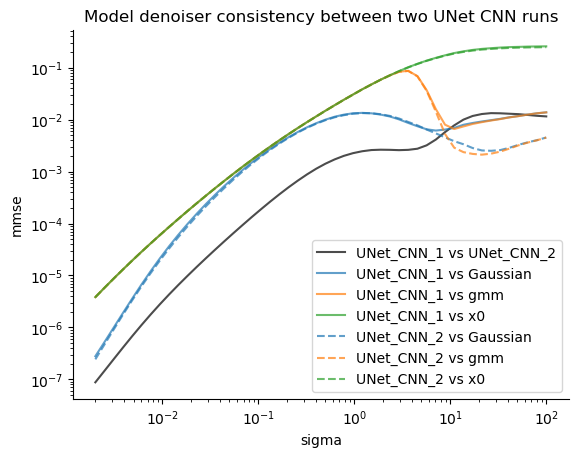

In [26]:
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_UNet_CNN_2", data=stats_df, label="UNet_CNN_1 vs UNet_CNN_2", alpha=0.7, lw=1.5, color="k")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_Gaussian", data=stats_df, label="UNet_CNN_1 vs Gaussian", alpha=0.7, lw=1.5, color="C0")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_gmm", data=stats_df, label="UNet_CNN_1 vs gmm", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_x0", data=stats_df, label="UNet_CNN_1 vs x0", alpha=0.7, lw=1.5, color="C2")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_Gaussian", data=stats_df, label="UNet_CNN_2 vs Gaussian", alpha=0.7, lw=1.5, color="C0", linestyle="--")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_gmm", data=stats_df, label="UNet_CNN_2 vs gmm", alpha=0.7, lw=1.5, color="C1", linestyle="--")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_x0", data=stats_df, label="UNet_CNN_2 vs x0", alpha=0.7, lw=1.5, color="C2", linestyle="--")
plt.xlabel("sigma")
plt.ylabel("mmse")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Model denoiser consistency between two UNet CNN runs")
plt.legend()
plt.show()

In [43]:
stats_col = []
for pairs in [("denoised_UNet_CNN_1", "denoised_UNet_CNN_2"), 
              ("denoised_MLP_1", "denoised_MLP_2"), 
              ("denoised_DiT_1", "denoised_DiT_2"),
              ("denoised_UNet_CNN_1", "denoised_MLP_1"), 
              ("denoised_UNet_CNN_1", "denoised_DiT_1"),
              ("denoised_MLP_1", "denoised_DiT_1"),
              ("denoised_UNet_CNN_1", "denoised_Gaussian"), 
              ("denoised_UNet_CNN_1", "denoised_gmm"),
              ("denoised_UNet_CNN_1", "x0"),
              ("denoised_UNet_CNN_2", "denoised_Gaussian"), 
              ("denoised_UNet_CNN_2", "denoised_gmm"),
              ("denoised_UNet_CNN_2", "x0"),
              ("denoised_DiT_1", "denoised_Gaussian"), 
              ("denoised_DiT_1", "denoised_gmm"),
              ("denoised_DiT_1", "x0"),
              ("denoised_DiT_2", "denoised_Gaussian"), 
              ("denoised_DiT_2", "denoised_gmm"),
              ("denoised_DiT_2", "x0"),
              ("denoised_MLP_1", "denoised_Gaussian"), 
              ("denoised_MLP_1", "denoised_gmm"),
              ("denoised_MLP_1", "x0"),
              ("denoised_MLP_2", "denoised_Gaussian"), 
              ("denoised_MLP_2", "denoised_gmm"),
              ("denoised_MLP_2", "x0"),
              ]:
    for i, denoiser_dict in enumerate(denoiser_cmp_col):
        sigma = denoiser_dict["sigma"]
        denoised_1 = denoiser_dict[pairs[0]]
        denoised_2 = denoiser_dict[pairs[1]]
        stats_row = {"sigma": sigma}
        pair0_name = pairs[0].replace("denoised_", "")
        pair1_name = pairs[1].replace("denoised_", "")
        mse_vec = torch.mean((denoised_1.cuda() - denoised_2.cuda()) ** 2, dim=-1)
        stats_row[f"mmse_{pair0_name}_to_{pair1_name}"] = mse_vec.mean().cpu().item()
        stats_row[f"mse_std_{pair0_name}_to_{pair1_name}"] = mse_vec.std().cpu().item()
        stats_col.append(stats_row)
stats_df = pd.DataFrame(stats_col)
# stats_df.to_csv("model_score_consistency_cmp.csv", index=False)

In [51]:
keys = list(denoiser_cmp_col[0].keys())[1:]

In [52]:
keys

['x0',
 'denoised_gmm',
 'denoised_Gaussian',
 'denoised_UNet_CNN_1',
 'denoised_UNet_CNN_2',
 'denoised_DiT_1',
 'denoised_DiT_2',
 'denoised_MLP_1',
 'denoised_MLP_2']

In [53]:
import itertools

stats_col = []
keys = list(denoiser_cmp_col[0].keys())[1:]
for pairs in itertools.combinations(keys, 2):
    for i, denoiser_dict in enumerate(denoiser_cmp_col):
        sigma = denoiser_dict["sigma"]
        denoised_1 = denoiser_dict[pairs[0]]
        denoised_2 = denoiser_dict[pairs[1]]
        stats_row = {"sigma": sigma}
        pair0_name = pairs[0].replace("denoised_", "")
        pair1_name = pairs[1].replace("denoised_", "")
        mse_vec = torch.mean((denoised_1.cuda() - denoised_2.cuda()) ** 2, dim=-1)
        stats_row[f"mmse_{pair0_name}_to_{pair1_name}"] = mse_vec.mean().cpu().item()
        stats_row[f"mse_std_{pair0_name}_to_{pair1_name}"] = mse_vec.std().cpu().item()
        stats_row[f"mmse_{pair1_name}_to_{pair0_name}"] = mse_vec.mean().cpu().item()
        stats_row[f"mse_std_{pair1_name}_to_{pair0_name}"] = mse_vec.std().cpu().item()
        stats_col.append(stats_row)
stats_df = pd.DataFrame(stats_col)

In [55]:
stats_df.to_csv(join(saveroot, "denoiser_consistency", "FFHQ32_model_denoiser_consistency_cmp.csv"), index=False)
figdir = "/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/denoiser_consistency_figs"
stats_df.to_csv(join(figdir, "FFHQ32_model_denoiser_consistency_cmp.csv"), index=False)

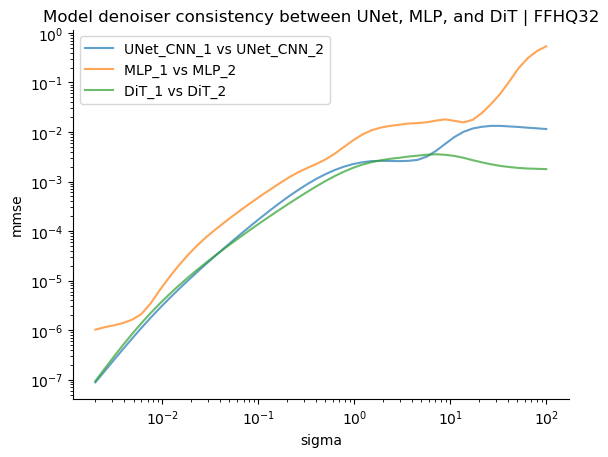

In [45]:
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_UNet_CNN_2", data=stats_df, label="UNet_CNN_1 vs UNet_CNN_2", alpha=0.7, lw=1.5, color="C0")
sns.lineplot(x="sigma", y="mmse_MLP_1_to_MLP_2", data=stats_df, label="MLP_1 vs MLP_2", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_DiT_1_to_DiT_2", data=stats_df, label="DiT_1 vs DiT_2", alpha=0.7, lw=1.5, color="C2")
# sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_x0", data=stats_df, label="UNet_CNN_1 vs x0", alpha=0.7, lw=1.5, color="C2")
# sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_Gaussian", data=stats_df, label="UNet_CNN_2 vs Gaussian", alpha=0.7, lw=1.5, color="C0", linestyle="--")
# sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_gmm", data=stats_df, label="UNet_CNN_2 vs gmm", alpha=0.7, lw=1.5, color="C1", linestyle="--")
# sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_x0", data=stats_df, label="UNet_CNN_2 vs x0", alpha=0.7, lw=1.5, color="C2", linestyle="--")
plt.xlabel("sigma")
plt.ylabel("mmse")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Model denoiser consistency between UNet, MLP, and DiT | FFHQ32")
plt.legend()
plt.show()

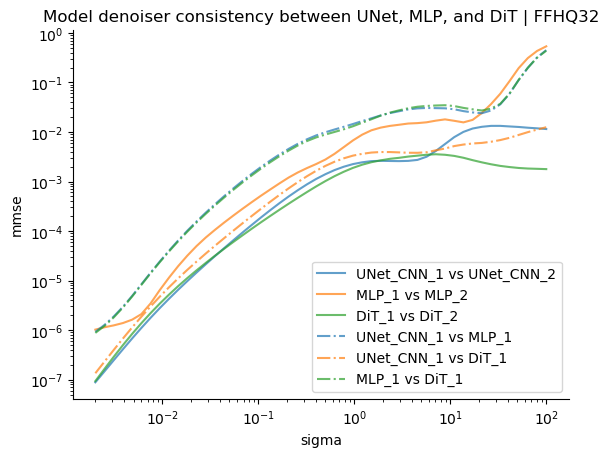

In [50]:
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_UNet_CNN_2", data=stats_df, label="UNet_CNN_1 vs UNet_CNN_2", alpha=0.7, lw=1.5, color="C0")
sns.lineplot(x="sigma", y="mmse_MLP_1_to_MLP_2", data=stats_df, label="MLP_1 vs MLP_2", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_DiT_1_to_DiT_2", data=stats_df, label="DiT_1 vs DiT_2", alpha=0.7, lw=1.5, color="C2")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_MLP_1", data=stats_df, label="UNet_CNN_1 vs MLP_1", alpha=0.7, lw=1.5, color="C0", linestyle="-.")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_DiT_1", data=stats_df, label="UNet_CNN_1 vs DiT_1", alpha=0.7, lw=1.5, color="C1", linestyle="-.")
sns.lineplot(x="sigma", y="mmse_MLP_1_to_DiT_1", data=stats_df, label="MLP_1 vs DiT_1", alpha=0.7, lw=1.5, color="C2", linestyle="-.")
plt.xlabel("sigma")
plt.ylabel("mmse")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Model denoiser consistency between UNet, MLP, and DiT | FFHQ32")
plt.legend()
plt.show()

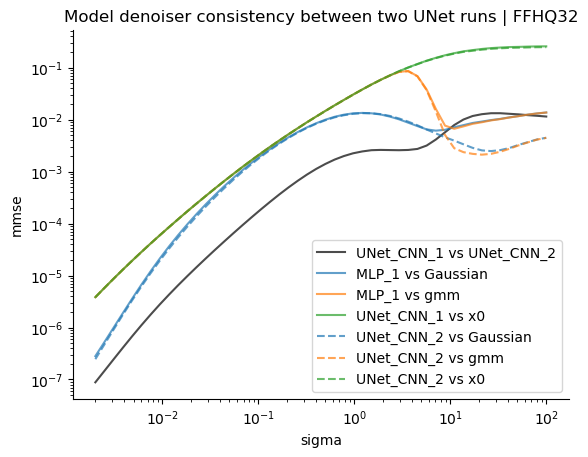

In [46]:
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_UNet_CNN_2", data=stats_df, label="UNet_CNN_1 vs UNet_CNN_2", alpha=0.7, lw=1.5, color="k")
# sns.lineplot(x="sigma", y="mmse_DiT_1_to_DiT_2", data=stats_df, label="DiT_1 vs DiT_2", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_Gaussian", data=stats_df, label="MLP_1 vs Gaussian", alpha=0.7, lw=1.5, color="C0")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_gmm", data=stats_df, label="MLP_1 vs gmm", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_x0", data=stats_df, label="UNet_CNN_1 vs x0", alpha=0.7, lw=1.5, color="C2")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_Gaussian", data=stats_df, label="UNet_CNN_2 vs Gaussian", alpha=0.7, lw=1.5, color="C0", linestyle="--")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_gmm", data=stats_df, label="UNet_CNN_2 vs gmm", alpha=0.7, lw=1.5, color="C1", linestyle="--")
sns.lineplot(x="sigma", y="mmse_UNet_CNN_2_to_x0", data=stats_df, label="UNet_CNN_2 vs x0", alpha=0.7, lw=1.5, color="C2", linestyle="--")
plt.xlabel("sigma")
plt.ylabel("mmse")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Model denoiser consistency between two UNet runs | FFHQ32")
plt.legend()
plt.show()

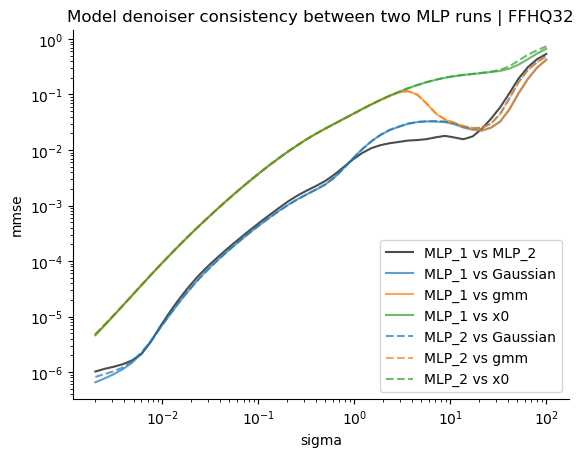

In [47]:
# sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_UNet_CNN_2", data=stats_df, label="UNet_CNN_1 vs UNet_CNN_2", alpha=0.7, lw=1.5, color="k")
sns.lineplot(x="sigma", y="mmse_MLP_1_to_MLP_2", data=stats_df, label="MLP_1 vs MLP_2", alpha=0.7, lw=1.5, color="k")
# sns.lineplot(x="sigma", y="mmse_DiT_1_to_DiT_2", data=stats_df, label="DiT_1 vs DiT_2", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_MLP_1_to_Gaussian", data=stats_df, label="MLP_1 vs Gaussian", alpha=0.7, lw=1.5, color="C0")
sns.lineplot(x="sigma", y="mmse_MLP_1_to_gmm", data=stats_df, label="MLP_1 vs gmm", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_MLP_1_to_x0", data=stats_df, label="MLP_1 vs x0", alpha=0.7, lw=1.5, color="C2")
sns.lineplot(x="sigma", y="mmse_MLP_2_to_Gaussian", data=stats_df, label="MLP_2 vs Gaussian", alpha=0.7, lw=1.5, color="C0", linestyle="--")
sns.lineplot(x="sigma", y="mmse_MLP_2_to_gmm", data=stats_df, label="MLP_2 vs gmm", alpha=0.7, lw=1.5, color="C1", linestyle="--")
sns.lineplot(x="sigma", y="mmse_MLP_2_to_x0", data=stats_df, label="MLP_2 vs x0", alpha=0.7, lw=1.5, color="C2", linestyle="--")
plt.xlabel("sigma")
plt.ylabel("mmse")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Model denoiser consistency between two MLP runs | FFHQ32")
plt.legend()
plt.show()

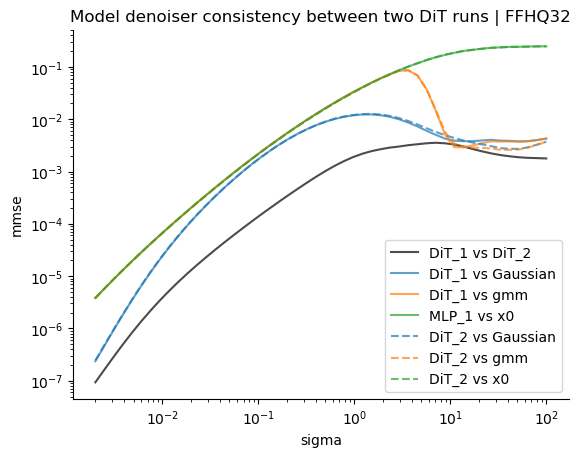

In [48]:
# sns.lineplot(x="sigma", y="mmse_UNet_CNN_1_to_UNet_CNN_2", data=stats_df, label="UNet_CNN_1 vs UNet_CNN_2", alpha=0.7, lw=1.5, color="k")
sns.lineplot(x="sigma", y="mmse_DiT_1_to_DiT_2", data=stats_df, label="DiT_1 vs DiT_2", alpha=0.7, lw=1.5, color="k")
# sns.lineplot(x="sigma", y="mmse_DiT_1_to_DiT_2", data=stats_df, label="DiT_1 vs DiT_2", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_DiT_1_to_Gaussian", data=stats_df, label="DiT_1 vs Gaussian", alpha=0.7, lw=1.5, color="C0")
sns.lineplot(x="sigma", y="mmse_DiT_1_to_gmm", data=stats_df, label="DiT_1 vs gmm", alpha=0.7, lw=1.5, color="C1")
sns.lineplot(x="sigma", y="mmse_DiT_1_to_x0", data=stats_df, label="MLP_1 vs x0", alpha=0.7, lw=1.5, color="C2")
sns.lineplot(x="sigma", y="mmse_DiT_2_to_Gaussian", data=stats_df, label="DiT_2 vs Gaussian", alpha=0.7, lw=1.5, color="C0", linestyle="--")
sns.lineplot(x="sigma", y="mmse_DiT_2_to_gmm", data=stats_df, label="DiT_2 vs gmm", alpha=0.7, lw=1.5, color="C1", linestyle="--")
sns.lineplot(x="sigma", y="mmse_DiT_2_to_x0", data=stats_df, label="DiT_2 vs x0", alpha=0.7, lw=1.5, color="C2", linestyle="--")
plt.xlabel("sigma")
plt.ylabel("mmse")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.title("Model denoiser consistency between two DiT runs | FFHQ32")
plt.legend()
plt.show()

In [ ]:
!ls -l /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_fixseed_DSM/

total 576424
-rw-rw-r--+ 1 binxuwang kempner_fellow_binxuwang       426 Jul 27 22:05 args.json
drwxrwsr-x+ 2 binxuwang kempner_fellow_binxuwang      4096 Jul 27 22:05 ckpts
-rw-rw-r--+ 1 binxuwang kempner_fellow_binxuwang        68 Jul 27 22:05 config.json
-rw-rw-r--+ 1 binxuwang kempner_fellow_binxuwang    259828 Jul 27 22:38 learned_samples_final.png
-rw-rw-r--+ 1 binxuwang kempner_fellow_binxuwang      7194 Jul 27 22:38 loss_store.pkl
-rw-rw-r--+ 1 binxuwang kempner_fellow_binxuwang    900331 Jul 27 22:38 loss_traj.pkl
-rw-rw-r--+ 1 binxuwang kempner_fellow_binxuwang 588976047 Jul 27 22:38 model_final.pth
drwxrwsr-x+ 2 binxuwang kempner_fellow_binxuwang     90112 Jul 27 22:38 samples


In [ ]:
!ls -d /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32*DSM

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_DiT_P2_192D_3H_6L_EDM_pilot_DSM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot_DSM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm_DSM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_B1024_fixseed_DSM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_B4096_fixseed_DSM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve/FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_DSM
/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiffusionSpectralLearningCurve

### Test 2: Denoiser similarity along Simplex spanned by points

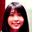

In [ ]:
to_imgrid((Xtsr_raw[55] * 0.5+0.5).clamp(0, 1))

In [ ]:
import torch.nn.functional as F

In [ ]:
# Load FFHQ 32x32 dataset
Xtsr_raw, imgsize = load_dataset("ffhq-32x32", normalize=True)
trainX_mean = Xtsr_raw.cuda().flatten(1).mean(dim=0).cpu()
trainX_cov = torch.cov(Xtsr_raw.cuda().flatten(1).T).cpu()
eigval, eigvec = torch.linalg.eigh(trainX_cov.cuda())

Target image index: 5042
Closest image indices: 11955, 13704
Distances: 286.0689, 303.4279


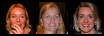

In [70]:
img_idx1 = 5042
# Find the two images closest to img_idx1
target_img = Xtsr_raw[img_idx1].unsqueeze(0)
distances = (Xtsr_raw - target_img).pow(2).sum(dim=[1,2,3])
distances[img_idx1] = float('inf')  # Exclude the target image itself
closest_indices = torch.topk(distances, 2, largest=False).indices
img_idx2, img_idx3 = closest_indices[0].item(), closest_indices[1].item()
print(f"Target image index: {img_idx1}")
print(f"Closest image indices: {img_idx2}, {img_idx3}")
print(f"Distances: {distances[img_idx2]:.4f}, {distances[img_idx3]:.4f}")
display(to_imgrid((Xtsr_raw[[img_idx1, img_idx2, img_idx3]] * 0.5 + 0.5).clamp(0, 1)))

Target image index: 6000
Closest image indices: 3601, 29960
Distances: 241.0002, 287.4546


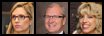

In [73]:
img_idx1 = 6000
# Find the two images closest to img_idx1
target_img = Xtsr_raw[img_idx1].unsqueeze(0)
distances = (Xtsr_raw - target_img).pow(2).sum(dim=[1,2,3])
distances[img_idx1] = float('inf')  # Exclude the target image itself
closest_indices = torch.topk(distances, 2, largest=False).indices
img_idx2, img_idx3 = closest_indices[0].item(), closest_indices[1].item()
print(f"Target image index: {img_idx1}")
print(f"Closest image indices: {img_idx2}, {img_idx3}")
print(f"Distances: {distances[img_idx2]:.4f}, {distances[img_idx3]:.4f}")
display(to_imgrid((Xtsr_raw[[img_idx1, img_idx2, img_idx3]] * 0.5 + 0.5).clamp(0, 1)))

Target image index: 555
Closest image indices: 43924, 10309
Distances: 461.1168, 472.9820


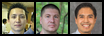

In [64]:
img_idx1 = 555
# Find the two images closest to img_idx1
target_img = Xtsr_raw[img_idx1].unsqueeze(0)
distances = (Xtsr_raw - target_img).pow(2).sum(dim=[1,2,3])
distances[img_idx1] = float('inf')  # Exclude the target image itself
closest_indices = torch.topk(distances, 2, largest=False).indices
img_idx2, img_idx3 = closest_indices[0].item(), closest_indices[1].item()
print(f"Target image index: {img_idx1}")
print(f"Closest image indices: {img_idx2}, {img_idx3}")
print(f"Distances: {distances[img_idx2]:.4f}, {distances[img_idx3]:.4f}")
display(to_imgrid((Xtsr_raw[[img_idx1, img_idx2, img_idx3]] * 0.5 + 0.5).clamp(0, 1)))

Target image index: 55
Closest image indices: 37024, 7903
Distances: 885.9139, 955.2939


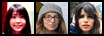

In [71]:
img_idx1 = 55
# Find the two images closest to img_idx1
target_img = Xtsr_raw[img_idx1].unsqueeze(0)
distances = (Xtsr_raw - target_img).pow(2).sum(dim=[1,2,3])
distances[img_idx1] = float('inf')  # Exclude the target image itself
closest_indices = torch.topk(distances, 2, largest=False).indices
img_idx2, img_idx3 = closest_indices[0].item(), closest_indices[1].item()
print(f"Target image index: {img_idx1}")
print(f"Closest image indices: {img_idx2}, {img_idx3}")
print(f"Distances: {distances[img_idx2]:.4f}, {distances[img_idx3]:.4f}")
display(to_imgrid((Xtsr_raw[[img_idx1, img_idx2, img_idx3]] * 0.5 + 0.5).clamp(0, 1)))

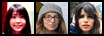

In [63]:
display(to_imgrid((Xtsr_raw[[55, 37024, 7903]] * 0.5 + 0.5).clamp(0, 1)))

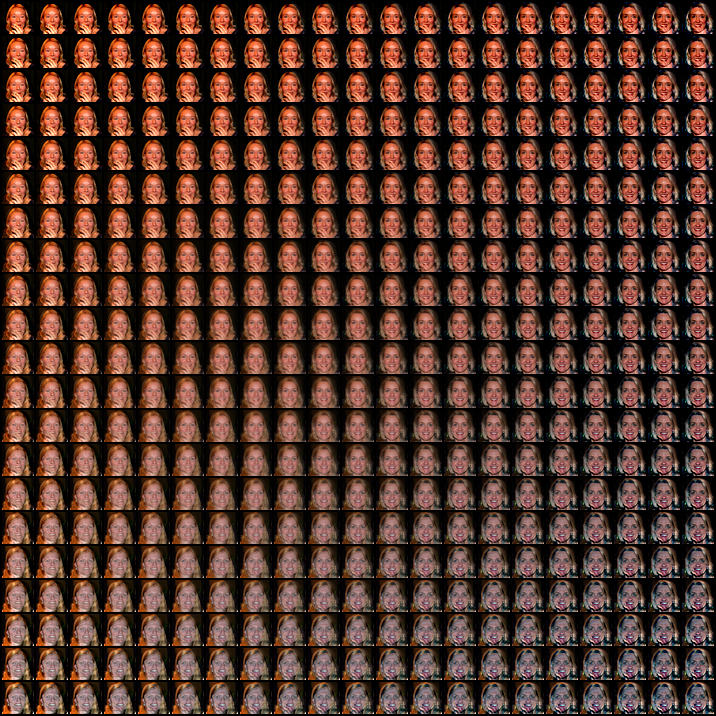

Generated 21x21 grid of samples on plane spanned by images [5042, 11955, 13704]
Grid shape: torch.Size([21, 21, 3, 32, 32])


In [111]:
# Create a plane spanned by three samples and sample points on a grid
img_indices = [5042, 11955, 13704]  # Three sample indices from previous analysis
samples = Xtsr_raw[img_indices]  # Shape: (3, C, H, W)

# Use the first sample as origin, and the other two as basis vectors
origin = samples[0]  # Shape: (C, H, W)
v1 = samples[1] - origin  # Vector from origin to second sample
v2 = samples[2] - origin  # Vector from origin to third sample
# Orthogonalize v2 with respect to v1 using Gram-Schmidt process
v1_dot_v1 = torch.sum(v1 * v1)
v1_dot_v2 = torch.sum(v1 * v2)
v2 = v2 - (v1_dot_v2 / v1_dot_v1) * v1
sample2_y_coord = v2.norm()
sample2_x_coord = v1_dot_v2 / v1.norm()
v2 = v2 / torch.norm(v2) * torch.norm(v1)
sample2_x_coord_scaled = sample2_x_coord / v1.norm()
sample2_y_coord_scaled = sample2_y_coord / v2.norm()
# Create a grid of interpolation coefficients
grid_size = 21  # 5x5 grid
alphas = torch.linspace(-0.5, 1.5, grid_size)
betas = torch.linspace(-0.5, 1.5, grid_size)

# Generate grid points on the plane
plane_samples = []
for alpha in alphas:
    row_samples = []
    for beta in betas:
        # Point on plane: origin + alpha * v1 + beta * v2
        point = origin + alpha * v1 + beta * v2
        row_samples.append(point)
    plane_samples.append(torch.stack(row_samples))

plane_grid = torch.stack(plane_samples)  # Shape: (grid_size, grid_size, C, H, W)

# Display the grid of samples
plane_grid_flat = plane_grid.view(-1, *plane_grid.shape[2:])  # Flatten to (25, C, H, W)
plane_grid_display = (plane_grid_flat * 0.5 + 0.5).clamp(0, 1)

# Create a grid visualization
display(to_imgrid(plane_grid_display, nrow=grid_size))

print(f"Generated {grid_size}x{grid_size} grid of samples on plane spanned by images {img_indices}")
print(f"Grid shape: {plane_grid.shape}")

In [80]:
model_precd_cnn1, _, config1 = load_pretrained_model("FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm", model_type="UNet")
model_precd_cnn2, _, config2 = load_pretrained_model("FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm_DSM", model_type="UNet")
model_precd_DiT1, _, _ = load_pretrained_model("FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot", model_type="DiT")
model_precd_DiT2, _, _ = load_pretrained_model("FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot_DSM", model_type="DiT")
model_precd_MLP1, _, _ = load_pretrained_model("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_DSM", model_type="MLP")
model_precd_MLP2, _, _ = load_pretrained_model("FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_fixseed_DSM", model_type="MLP")
models_dict = {
    "UNet_CNN_1": lambda Xt, sigma: model_precd_cnn1(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "UNet_CNN_2": lambda Xt, sigma: model_precd_cnn2(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "DiT_1": lambda Xt, sigma: model_precd_DiT1(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "DiT_2": lambda Xt, sigma: model_precd_DiT2(Xt.view(-1, 3, 32, 32), sigma).view(Xt.shape[0], -1),
    "MLP_1": lambda Xt, sigma: model_precd_MLP1(Xt, sigma),
    "MLP_2": lambda Xt, sigma: model_precd_MLP2(Xt, sigma),
}

Loading CNN UNet model with config:  {'channels': 3, 'img_size': 32, 'layers_per_block': 1, 'decoder_init_attn': True, 'attn_resolutions': [8], 'model_channels': 128, 'channel_mult': [1, 2, 2, 2], 'dropout': 0.0, 'label_dim': 0, 'augment_dim': 0}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Total number of parameters in the model: 28183299 | trainable: 28183299
Loading CNN UNet model with config:  {'channels': 3, 'img_size': 32, 'layers_per_block': 1, 'decoder_init_attn': True, 'attn_resolutions': [8], 'model_channels': 128, 'channel_mult': [1, 2, 2, 2], 'dropout': 0.0, 'label_dim': 0, 'augment_dim': 0}
total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299
Total number of parameters in the model: 28183299 | trainable: 28183299
Loading DiT model with config:  {'input_size': 32, 'in_channels': 3, 'patch_size': 2, 'hidden_size': 384, 'depth': 6, 

In [112]:
plane_grid_denoised_col = compute_model_denoisers_cmp_at_reference(models_dict, plane_grid_flat.flatten(1), pnts=Xtsr_raw.flatten(1), device="cuda", num_noise_levels=50, 
                                                                   batch_size=None, eigval=eigval, eigvec=eigvec)

100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


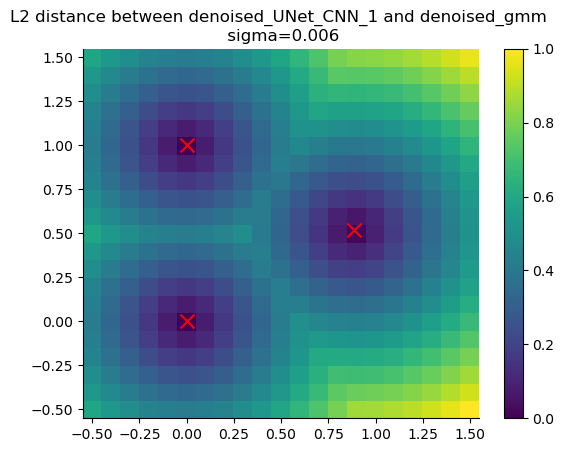

In [115]:
sigma_i = 5
sigma = plane_grid_denoised_col[sigma_i]["sigma"]
pair0, pair1 = "denoised_UNet_CNN_1", "denoised_UNet_CNN_2"
pair0, pair1 = "denoised_UNet_CNN_1", "denoised_gmm"
distances = torch.norm(plane_grid_denoised_col[sigma_i][pair0] - plane_grid_denoised_col[sigma_i][pair1], dim=-1)
dist_mat = distances.reshape(grid_size, grid_size)
plt.pcolor(alphas, betas, dist_mat)
plt.scatter([0, 0, sample2_y_coord_scaled], [0, 1, sample2_x_coord_scaled], color="red", marker="x", s=100)
plt.title(f"L2 distance between {pair0} and {pair1} \n sigma={sigma:.3f}")
plt.colorbar()
plt.show()

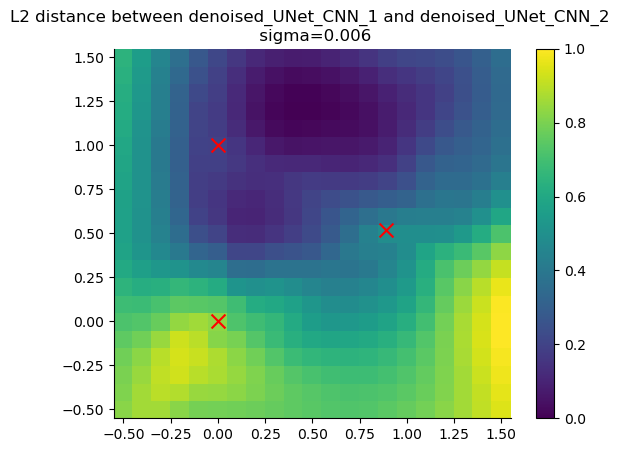

In [116]:
sigma_i = 5
sigma = plane_grid_denoised_col[sigma_i]["sigma"]
pair0, pair1 = "denoised_UNet_CNN_1", "denoised_UNet_CNN_2"
# pair0, pair1 = "denoised_UNet_CNN_1", "denoised_gmm"
distances = torch.norm(plane_grid_denoised_col[sigma_i][pair0] - plane_grid_denoised_col[sigma_i][pair1], dim=-1)
dist_mat = distances.reshape(grid_size, grid_size)
plt.pcolor(alphas, betas, dist_mat)
plt.scatter([0, 0, sample2_y_coord_scaled], [0, 1, sample2_x_coord_scaled], color="red", marker="x", s=100)
plt.title(f"L2 distance between {pair0} and {pair1} \n sigma={sigma:.3f}")
plt.colorbar()
plt.show()

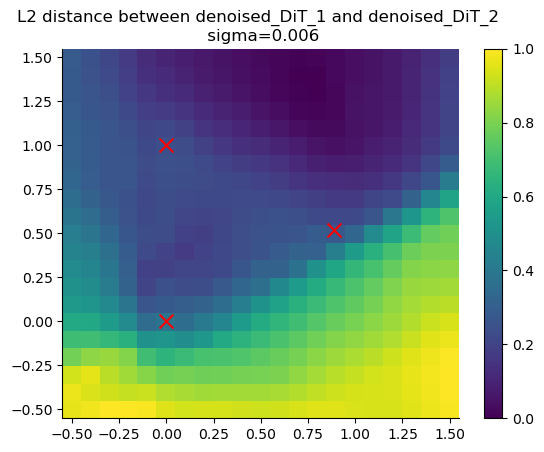

In [117]:
sigma_i = 5
sigma = plane_grid_denoised_col[sigma_i]["sigma"]
pair0, pair1 = "denoised_DiT_1", "denoised_DiT_2"
# pair0, pair1 = "denoised_UNet_CNN_1", "denoised_gmm"
distances = torch.norm(plane_grid_denoised_col[sigma_i][pair0] - plane_grid_denoised_col[sigma_i][pair1], dim=-1)
dist_mat = distances.reshape(grid_size, grid_size)
plt.pcolor(alphas, betas, dist_mat)
plt.scatter([0, 0, sample2_y_coord_scaled], [0, 1, sample2_x_coord_scaled], color="red", marker="x", s=100)
plt.title(f"L2 distance between {pair0} and {pair1} \n sigma={sigma:.3f}")
plt.colorbar()
plt.show()

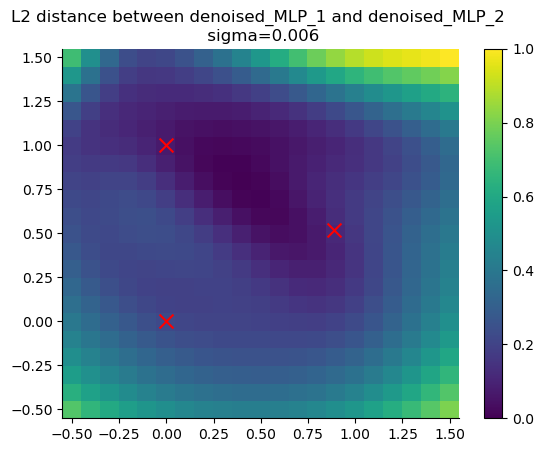

In [118]:
sigma_i = 5
sigma = plane_grid_denoised_col[sigma_i]["sigma"]
pair0, pair1 = "denoised_MLP_1", "denoised_MLP_2"
# pair0, pair1 = "denoised_UNet_CNN_1", "denoised_gmm"
distances = torch.norm(plane_grid_denoised_col[sigma_i][pair0] - plane_grid_denoised_col[sigma_i][pair1], dim=-1)
dist_mat = distances.reshape(grid_size, grid_size)
plt.pcolor(alphas, betas, dist_mat)
plt.scatter([0, 0, sample2_y_coord_scaled], [0, 1, sample2_x_coord_scaled], color="red", marker="x", s=100)
plt.title(f"L2 distance between {pair0} and {pair1} \n sigma={sigma:.3f}")
plt.colorbar()
plt.show()

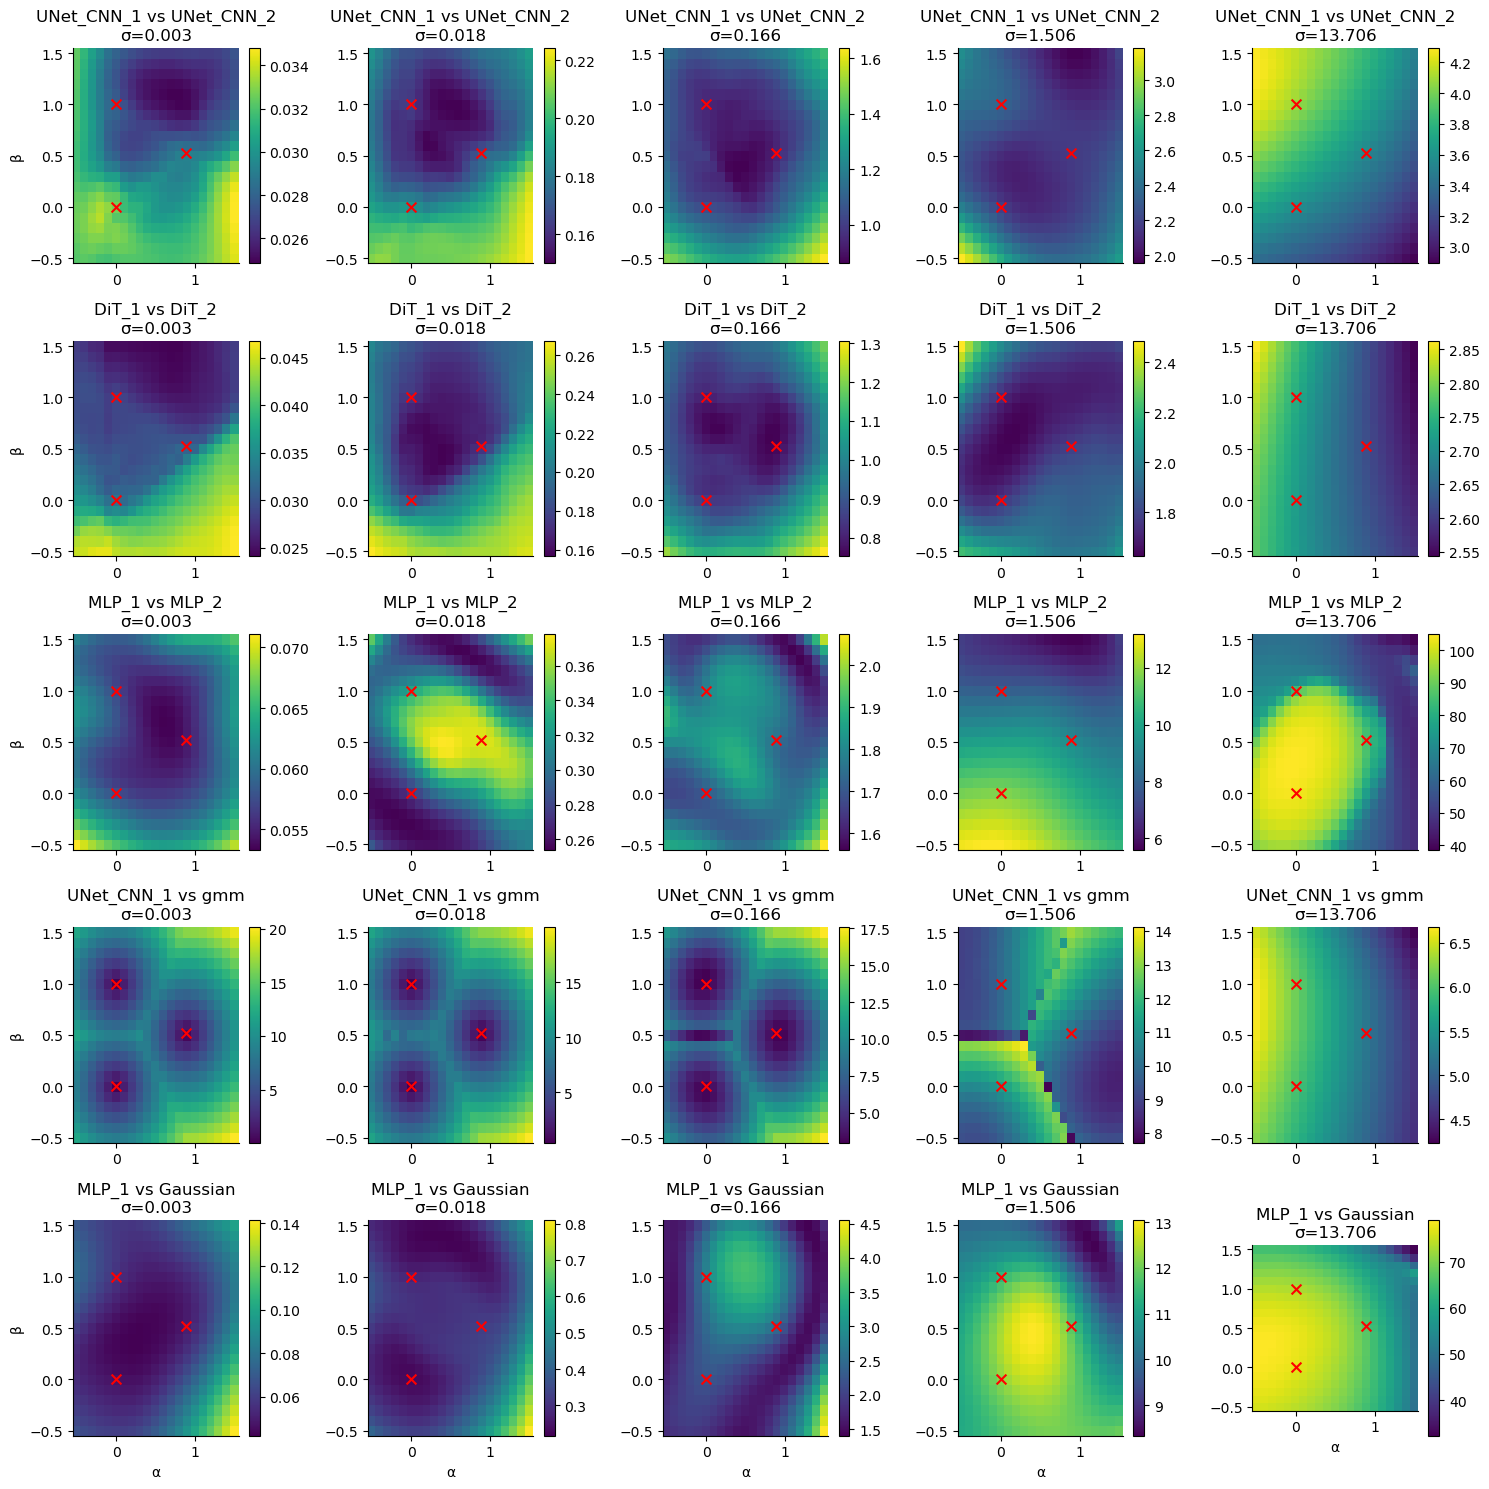

In [127]:
# Define pairs and sigma indices for systematic plotting
pair_types = [
    ("denoised_UNet_CNN_1", "denoised_UNet_CNN_2"),
    ("denoised_DiT_1", "denoised_DiT_2"), 
    ("denoised_MLP_1", "denoised_MLP_2"),
    ("denoised_UNet_CNN_1", "denoised_gmm"),
    ("denoised_MLP_1", "denoised_Gaussian"),
]
sigma_indices = [2, 10, 20, 30, 40]

fig, axes = plt.subplots(len(pair_types), len(sigma_indices), figsize=(len(sigma_indices) * 3, len(pair_types) * 3))

for row_i, (pair0, pair1) in enumerate(pair_types):
    for col_i, sigma_i in enumerate(sigma_indices):
        ax = axes[row_i, col_i]
        sigma = plane_grid_denoised_col[sigma_i]["sigma"]
        
        distances = torch.norm(plane_grid_denoised_col[sigma_i][pair0] - plane_grid_denoised_col[sigma_i][pair1], dim=-1)
        dist_mat = distances.reshape(grid_size, grid_size)
        
        im = ax.pcolor(alphas, betas, dist_mat)
        ax.scatter([0, 0, sample2_y_coord_scaled], [0, 1, sample2_x_coord_scaled], color="red", marker="x", s=50)
        ax.set_title(f"{pair0.replace('denoised_', '')} vs {pair1.replace('denoised_', '')}\nσ={sigma:.3f}")
        plt.axis("image")
        if row_i == len(pair_types) - 1:
            ax.set_xlabel("α")
        if col_i == 0:
            ax.set_ylabel("β")
            
        plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

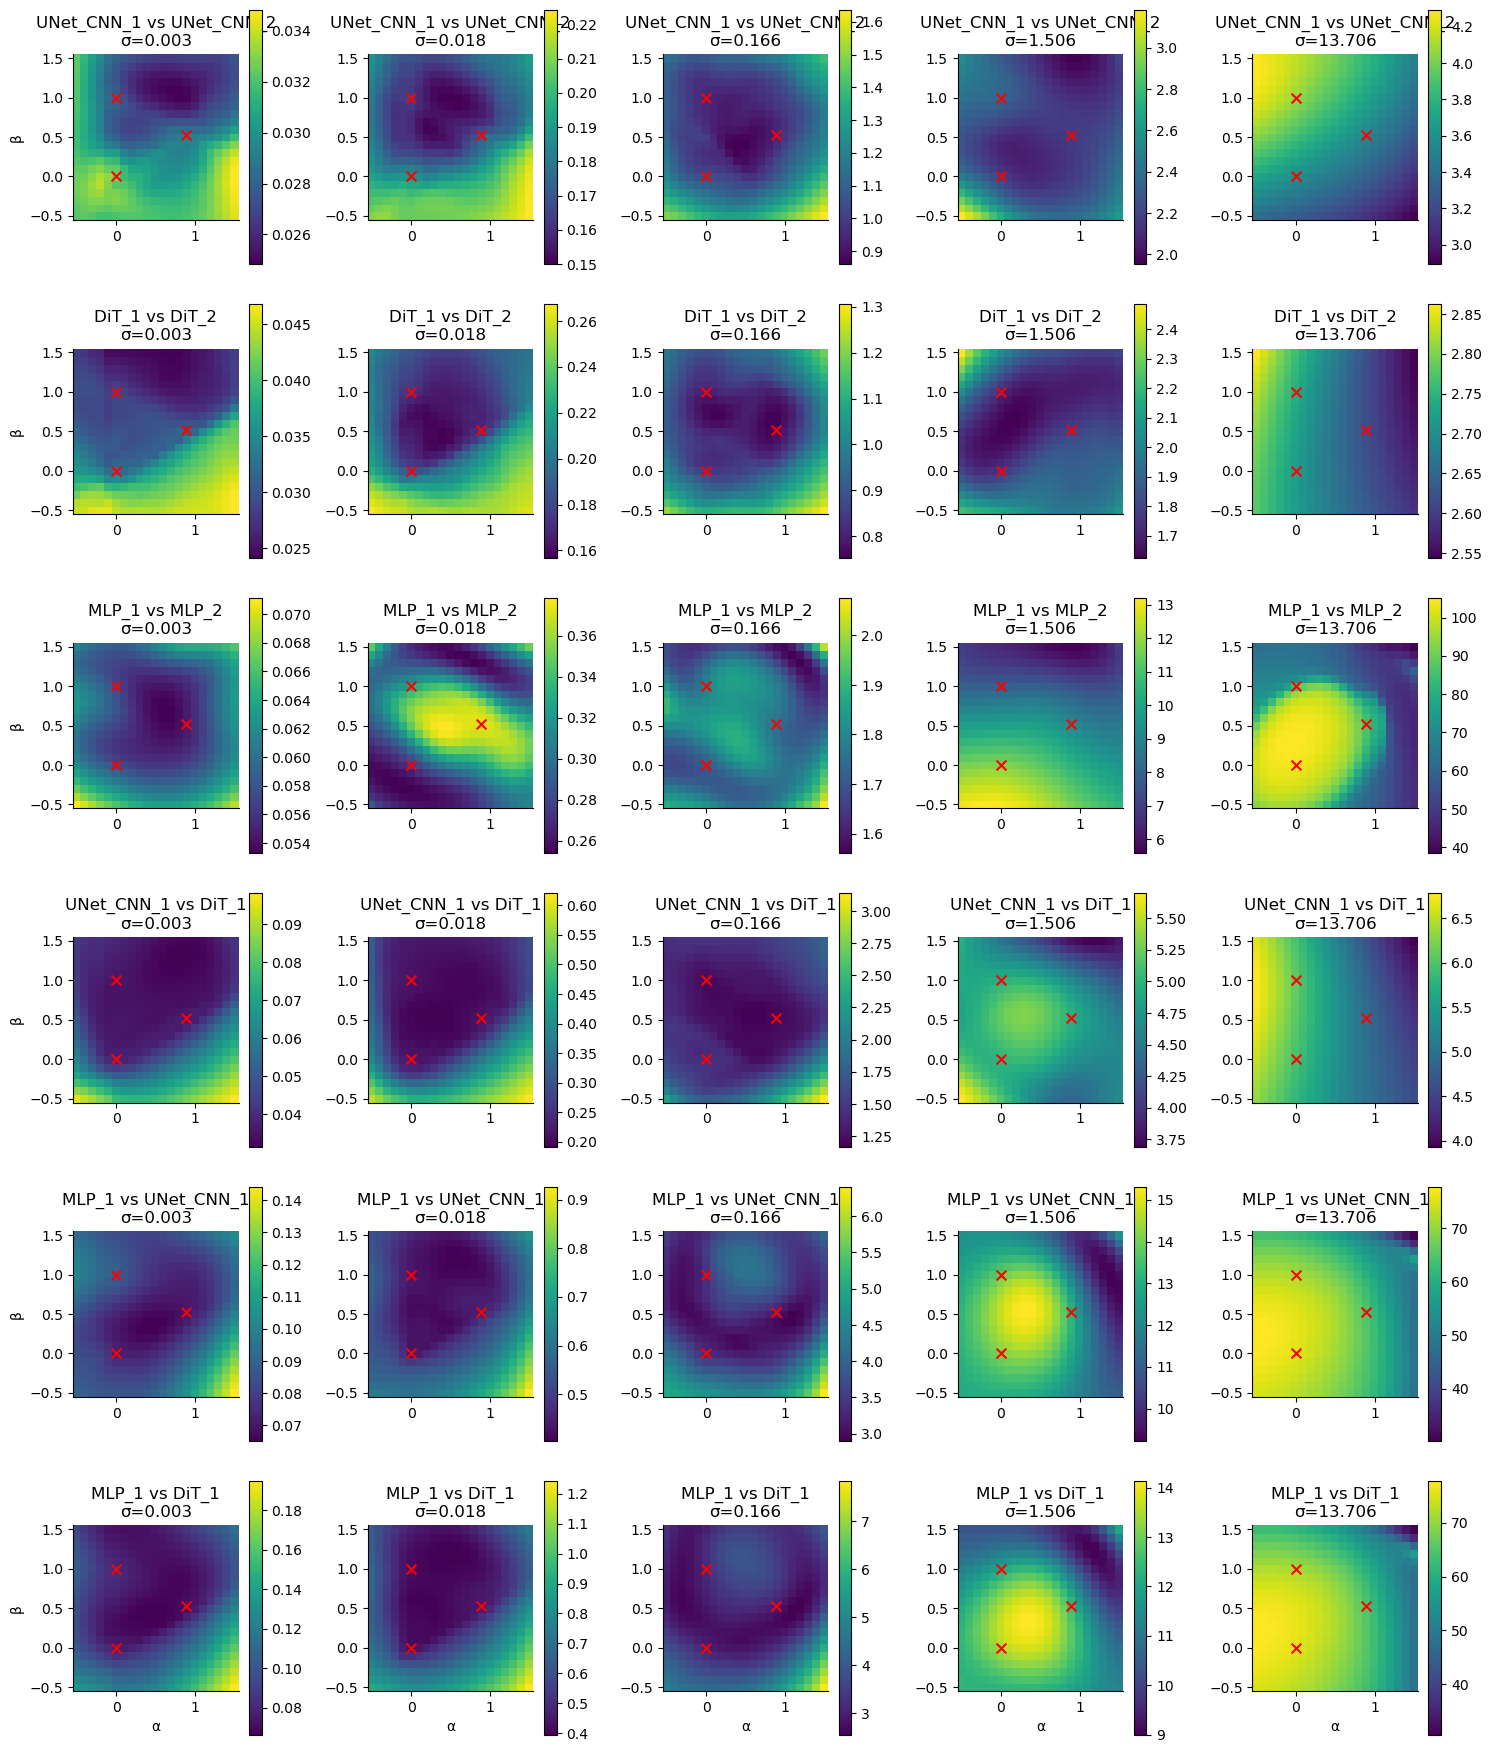

In [126]:
# Define pairs and sigma indices for systematic plotting
pair_types = [
    ("denoised_UNet_CNN_1", "denoised_UNet_CNN_2"),
    ("denoised_DiT_1", "denoised_DiT_2"), 
    ("denoised_MLP_1", "denoised_MLP_2"),
    ("denoised_UNet_CNN_1", "denoised_DiT_1"),
    ("denoised_MLP_1", "denoised_UNet_CNN_1"),
    ("denoised_MLP_1", "denoised_DiT_1"),
]
sigma_indices = [2, 10, 20, 30, 40]

fig, axes = plt.subplots(len(pair_types), len(sigma_indices), figsize=(len(sigma_indices) * 3, len(pair_types) * 3))

for row_i, (pair0, pair1) in enumerate(pair_types):
    for col_i, sigma_i in enumerate(sigma_indices):
        ax = axes[row_i, col_i]
        sigma = plane_grid_denoised_col[sigma_i]["sigma"]
        
        distances = torch.norm(plane_grid_denoised_col[sigma_i][pair0] - plane_grid_denoised_col[sigma_i][pair1], dim=-1)
        dist_mat = distances.reshape(grid_size, grid_size)
        
        im = ax.pcolor(alphas, betas, dist_mat)
        ax.scatter([0, 0, sample2_y_coord_scaled], [0, 1, sample2_x_coord_scaled], color="red", marker="x", s=50)
        ax.set_title(f"{pair0.replace('denoised_', '')} vs {pair1.replace('denoised_', '')}\nσ={sigma:.3f}")
        ax.axis("image")
        # ax.axis("tight")
        if row_i == len(pair_types) - 1:
            ax.set_xlabel("α")
        if col_i == 0:
            ax.set_ylabel("β")
            
        plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [90]:
33792 / 3072

11.0

### Scratch

In [ ]:
from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone, EDMPrecondWrapper
import json
expname = "FFHQ32_UNet_MLP_EDM_8L_3072D_lr1e-4_fixseed_DSM"
expdir = join(saveroot, expname)
model_dict = torch.load(join(expdir, "model_final.pth"))
config = json.load(open(join(expdir, "config.json")))
model = UNetBlockStyleMLP_backbone(**config)
model.load_state_dict(torch.load(join(expdir, "model_final.pth")))
model_precd_MLP = EDMPrecondWrapper(model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)

/tmp/ipykernel_276239/2057874174.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(join(expdir, "model_final.pth"))
/tmp/ipykernel_276239/205787417

In [ ]:
from core.network_edm_lib import SongUNet, DhariwalUNet, create_unet_model
from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone, EDMPrecondWrapper, EDMCNNPrecondWrapper, EDMDiTPrecondWrapper
import json
from easydict import EasyDict as edict
expname = "FFHQ32_UNet_CNN_EDM_4blocks_wide128_attn_pilot_fixednorm_DSM"
expdir = join(saveroot, expname)
# model_dict = torch.load(join(expdir, "model_final.pth"))
config = json.load(open(join(expdir, "config.json")))
unet = create_unet_model(edict(config))
unet.load_state_dict(torch.load(join(expdir, "model_final.pth")))
model_precd_CNN = EDMCNNPrecondWrapper(unet, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
model_precd_CNN = model_precd_CNN.to("cuda").eval();

total number of trainable parameters in the Score Model: 28183299
total number of parameters in the Score Model: 28183299


/tmp/ipykernel_276239/3026128272.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load(join(expdir, "model_final.pth")))


In [ ]:
from core.diffusion_edm_lib import UNetBlockStyleMLP_backbone, EDMPrecondWrapper, EDMCNNPrecondWrapper, EDMDiTPrecondWrapper
from core.DiT_model_lib import *
expname = "FFHQ32_DiT_P2_384D_6H_6L_EDM_pilot_DSM"
expdir = join(saveroot, expname)
config = json.load(open(join(expdir, "config.json")))
DiT_model = DiT(**config)
DiT_model.load_state_dict(torch.load(join(expdir, "model_final.pth")))
model_precd_DiT = EDMDiTPrecondWrapper(DiT_model, sigma_data=0.5, sigma_min=0.002, sigma_max=80, rho=7.0)
model_precd_DiT = model_precd_DiT.cuda().eval()

/tmp/ipykernel_276239/1789147504.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  DiT_model.load_state_dict(torch.load(join(expdir, "model_final.pth")))


In [ ]:
# Load models and compute comparison
device = "cuda"
models_dict = {
    "MLP_DSM": model_precd_MLP.cuda(),
    "CNN_DSM": lambda Xt, sigma: model_precd_CNN(Xt.view(Xt.shape[0], 3, 32, 32), sigma).flatten(1),
    "DiT_DSM": lambda Xt, sigma: model_precd_DiT(Xt.view(Xt.shape[0], 3, 32, 32), sigma).flatten(1),
}

stats_df, mmse_all_col = compute_model_mmse_comparison(models_dict, Xtsr_raw.flatten(1), device, num_reps=0.15, num_noise_levels=30, batch_size=1024, 
                                         eigval=eigval, eigvec=eigvec)
# stats_df.to_csv(join(savedir, "stats_col.csv"), index=False)

100%|██████████| 30/30 [04:42<00:00,  9.40s/it]


In [ ]:
figdir = r"/n/home12/binxuwang/Github/DiffusionLearningCurve/figures/DSM_vs_ESM_FFHQ32_MLP_DIT_CNN_cmp"
# stats_df.to_csv(join(figdir, "mmse_gmm_denoiser_cmp.csv"), index=False)
stats_df.to_csv(join(figdir, "mmse_dnn_gmm_Gaussian_denoiser_cmp.csv"), index=False)
pkl.dump(mmse_all_col, open(join(figdir, "mmse_dnn_gmm_Gaussian_denoiser_cmp.pkl"), "wb"))

In [ ]:
stats_df

,sigma,mmse_MLP_DSM_to_gmm,mmse_MLP_DSM_to_x0,mmse_CNN_DSM_to_gmm,mmse_CNN_DSM_to_x0,mmse_DiT_DSM_to_gmm,mmse_DiT_DSM_to_x0,mmse_gmm_to_x0
0,0.002000,0.000005,0.000005,0.000004,0.000004,0.000004,0.000004,0.000000e+00
1,0.002904,0.000009,0.000009,0.000008,0.000008,0.000008,0.000008,0.000000e+00
2,0.004218,0.000019,0.000019,0.000015,0.000015,0.000015,0.000015,0.000000e+00
3,0.006125,0.000038,0.000038,0.000029,0.000029,0.000029,0.000029,0.000000e+00
4,0.008895,0.000075,0.000075,0.000054,0.000054,0.000055,0.000055,0.000000e+00
5,0.012918,0.000148,0.000148,0.000100,0.000100,0.000102,0.000102,0.000000e+00
6,0.018760,0.000282,0.000282,0.000181,0.000181,0.000184,0.000184,0.000000e+00
7,0.027244,0.000524,0.000524,0.000321,0.000321,0.000328,0.000328,0.000000e+00
8,0.039564,0.000949,0.000949,0.000561,0.000561,0.000576,0.000576,0.000000e+00
9,0.057455,0.001677,0.001677,0.000963,0.000963,0.000995,0.000995,0.000000e+00
